# 디렉토리 설정 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/DataSet/KYR_B_imaging.zip
!cp '/content/drive/MyDrive/Colab Notebooks/Repositary/MRI_classification/utils/init.py' ./ 

In [11]:
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr3' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr2 74' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr5' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr7' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr4' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/nswr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr6' '/content/KYR_B_imaging' 
!rm -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱'

# 초기작업
- 데이터 제너레이터에 넣을 수 있는 기본형태를 만드는 것 

## 기본 DF 생성 
- csv 데이터인 snsb_df 
- 이미지 디렉토리 관련인 dir_df만듬 

전처리 과정에서 
- snsb_df -> csvs 
- dir_df -> new_dir_df로 변환 함 


In [12]:
import os 
import cv2 
import pandas as pd 
from glob import glob
from tqdm import tqdm
from init import init #초기 설정용 커스텀 패키지 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as cm 
import warnings
warnings.filterwarnings('ignore')
from albumentations import (
    Rotate,Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate,JpegCompression,RandomBrightness,
    HorizontalFlip,RandomBrightnessContrast,Crop
)

###snsb_df 생성 
- 환자 정보 데이터 프레임 

In [13]:
columns = ['성명',
 '병록번호',
 '만나이',
 '검사일',
 '교육년수',
 'SVLT_recall_total_score_z',
 'SVLT_Delayed_recall_z',
 'SVLT_recognition_score_z',
 'RCFT_immediate_recall_z',
 'RCFT_delayed_recall_z',
 'RCFT_recognition_score_z',
 'K_MMSE_total_score_z',
 'SNSB_II_Domain_Attention_z',
 'SNSB_II_Domain_Language_z',
 'SNSB_II_Domain_Visuospatial_z',
 'SNSB_II_Domain_Memory_z',
 'SNSB_II_Domain_Frontal_z']

snsb_df = pd.read_csv('/content/drive/MyDrive/DataSet/202202_김예림/SNSB_integerated.csv')
snsb_df = snsb_df.drop([2098,2591]) #병록번호 없는 행 제거 <- 결측치 
snsb_df['병록번호'] = snsb_df['병록번호'].apply(lambda x : str(int(x))) #소수점으로 되어 있는 것 처리하고 str형 변형 

snsb_df = snsb_df[columns]

## 결측치 처리 

#컬럼 중 isnull 검색 
#검색한 표본들의 평균 나이 
#평균 나이로 원래  csvs 검색 
#해당 나이로 검색 된 것들의 평균 값으로 insull 채움 

null_columns = ['RCFT_immediate_recall_z',
                'SVLT_recall_total_score_z',
                'SVLT_Delayed_recall_z',
                'SVLT_recognition_score_z',
'RCFT_delayed_recall_z',            
'RCFT_recognition_score_z',        
'K_MMSE_total_score_z',           
'SNSB_II_Domain_Attention_z',       
'SNSB_II_Domain_Language_z',        
'SNSB_II_Domain_Visuospatial_z',    
'SNSB_II_Domain_Memory_z',          
'SNSB_II_Domain_Frontal_z']         

for null_column in null_columns:
  try:
    null_age = int(np.mean(snsb_df[snsb_df[null_column].isnull()]['만나이']))
    null_value = np.mean(snsb_df[snsb_df['만나이']==null_age][null_column].dropna())
    snsb_df.loc[snsb_df[null_column].isnull(),null_column] = null_value
  except:
    pass

###dir_df 생성 
- 환자  별 mri 디렉토리 데이터 프레임 
- 이미지 장수 정리 안된 데이터 프레임 

In [14]:
#폴더 디렉토리
folder_dir = glob('/content/KYR_B_imaging/*')
dir_df = init.dir_df(folder_dir)
dir_df = dir_df.sort_values(by=['key','dir'])
dir_df = dir_df.reset_index().drop(columns = 'index')

### 병록번호- key 값 보정
- 병록번호 == key 하게 만들어야 함 -> primary key 
- 중복 제거, @@@-1 형태 제거, 9자리로 통일 

In [15]:
target_length = [4,5,6,7,8] #<- 수정해야 하는 병록번호 갯수들 

dir_df,snsb_df = init.key_mismatch(dir_df,snsb_df,target_length)
#인덱스 초기화 
dir_df = dir_df.reset_index().drop(columns = 'index')
# plt.hist(snsb_df['병록번호'].map(len))
# plt.show()

#에러값들 제외 
errors = ['000758836-1' '030338456-1' '040145556-1' '050236926-1' '090374796-1'
 '100402746-1' '120010356-1' '870133669-1' '920033543-1' '930236559-1'
 '930257597-1' '970682600-1']

dir_df = dir_df.drop(np.where(dir_df['key'].map(len)>9)[0])

## new_dir_df 생성 - 이미지 장수 통일 
- 위에서 만든 dir_df에서 각 key 별로 이미지 19장으로 맞춤 
- 19장으로 맞추는 이유는 가장 비율이 높아서 


### key 값 별 이미지 장수 연산 

In [16]:
#이미지 장수 연산 
keys = list(set(dir_df['key'])) 
images_length = pd.DataFrame(keys)[0].apply(lambda x: init.check_images(dir_df,x)) #키 값별로 이미지의 장수들 계산 
# images_length.value_counts()

length_df = pd.DataFrame([keys,images_length]).T
length_df.columns = ['key','image_length']
length_df['image_length']  = length_df['image_length'].map(int)

#Standard를 기준으로 less over 분할 
standard = 19 # 통일 시킬 이미지 장 수 기준 

# 조정이 필요한 장 수 초과하는 것들만 추림 
length_df_over = length_df[length_df['image_length']>standard]

#19장 보다 적은 경우 
# length_df_less = length_df[length_df['image_length']<standard]

len(length_df_over)

1606

### key값 별로 이미지 19장 있는 new_dir_df 생성 

In [17]:
new_dir_df = pd.DataFrame(np.zeros(len(length_df_over)*19*2).reshape(-1,2))
new_dir_df.columns = dir_df.columns

for index in tqdm(range(len(length_df_over))):
  new_dir_df.iloc[index*19:(index+1)*19,:]  = dir_df.loc[init.droped_indexes(dir_df,length_df_over,index,standard=19)]
new_dir_df = new_dir_df.sort_values(by=['key','dir'])
new_dir_df = new_dir_df.reset_index().drop(columns = 'index')

100%|██████████| 1606/1606 [00:12<00:00, 126.88it/s]


## csvs 생성 
 - 중복 제거 
 - z score -1.0를 기준으로 0(정상) 1(비정상)으로 분류 



In [18]:
#19장의 사진으로 추린 new_dir_df로 새로운 키 리스트만듬) 

key_lists = np.unique(new_dir_df['key'])
key_lists.sort()

Embedding_columns = snsb_df.columns[5:]

for column in Embedding_columns:
  snsb_df[f'E_{column}'] = snsb_df[column].map(init.zscore_Embedding)

#정렬 
snsb_df = snsb_df.sort_values(by=['병록번호'])
new_dir_df = new_dir_df.sort_values(by=['key','dir'])

#snsb_df 중 key_lists에 있는 행들만 추림 -> csvs 
csvs = snsb_df[snsb_df['병록번호'].apply(lambda x : x in key_lists)].sort_values(by=['병록번호'])
csvs = csvs.reset_index().drop(columns = 'index')

#중복 제거 : 이름으로 정렬 후 중복 제거 
csvs = csvs.sort_values(by=['성명'])
csvs = csvs.drop_duplicates(['병록번호'], keep = 'first')

#다시 병록번호 로 정렬 해서 csvs 와 new_dir_df 순을 맞춤 
csvs = csvs.sort_values(['병록번호'])
csvs = csvs.reset_index().drop(columns = 'index')
new_dir_df = new_dir_df.sort_values(by=['key','dir'])
new_dir_df = new_dir_df.reset_index().drop(columns = 'index')

#맞춤 확인 
print(len(csvs),len(np.unique(new_dir_df['key'])))

#shuffle 
key_lists = pd.DataFrame(key_lists).sample(frac=1).reset_index()
index = np.array(key_lists['index'])
key_lists = np.array(key_lists[0])
csvs = csvs.iloc[index]

1606 1606


# 전처리

## Augmentation 

In [19]:
import albumentations as A
transform = A.Compose([
    JpegCompression(quality_lower=85, 
                    quality_upper=100, p=0.5), 
    HueSaturationValue(hue_shift_limit=20,
                        sat_shift_limit=30, 
                    val_shift_limit=20, p=0.5),
    A.HorizontalFlip(p=0.5),
    Rotate(p=0.5, limit = 90)
])

## 이미지 전처리

In [20]:
#이미지 전처리 

def img_preprocess(img):
  shape = img.shape[0]
  preprocessed_img = img[int(shape*0.05):int(shape*0.95),int(shape*0.1):int(shape*0.9),:] #crop 
  preprocessed_img = transform(image=preprocessed_img)['image'] #augmentation
  preprocessed_img = cv2.cvtColor(preprocessed_img,cv2.COLOR_BGR2GRAY) #BGR -> GRAY scale 
  preprocessed_img = cv2.resize(preprocessed_img,dsize=(image_size,image_size)) #resize 
  preprocessed_img = preprocessed_img/255.#scaling 
  return preprocessed_img 


def key_to_dir(key,new_dir_df): #batch_key -> image directory 
  dir_of_key = new_dir_df[new_dir_df['key']==key]
  return dir_of_key



def read_imgs(img_dir_df):  #image directory -> stacked image 
  temp_imgs = np.zeros(image_size*image_size*image_channels).reshape(image_size,image_size,image_channels)
  for i in range(len(img_dir_df)):
    temp_img = img_dir_df['dir'].iloc[i]
    temp_img = img_preprocess(cv2.imread(temp_img))
    temp_imgs[:,:,i] = temp_img 
  return temp_imgs



# 데이터 제너레이터

키 리스트를 이용해 train, valid, test 분리 

In [21]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math


class DataGenerator(Sequence):
  def __init__(self,
                 new_dir_df,
                 csvs,
                 key_lists,
                 output_column,
                 batch_size: int,
                 augmentation: bool = False,
                 shuffle: bool = False,
                 rescale:bool = True) -> None:
        self.input_columns = input_columns 
        self.key_lists = key_lists
        self.output_columns = output_column
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.rescale =rescale
        self.new_dir_df = new_dir_df
        self.csvs = csvs

  def __len__(self):
    return math.ceil(len(self.key_lists) / self.batch_size)
    
  def on_epoch_end(self):
    self.indices = np.arange(len(self.key_lists))
    if self.shuffle == True:
      np.random.shuffle(self.indices)
      self.key_lists = self.key_lists[self.indices]
      
  def __getitem__(self, index):
    #key list에서 batch_keys 뽑아 냄 
    #이 batch_keys를 기반으로 image와 csv 추출 함 
    self.batch_keys = self.key_lists[index*self.batch_size:(index+1)*self.batch_size]
    self.batch_keys.sort()

    #imgs 추출 
    temp_imgs = []
    for key in range(len(self.batch_keys)):
      img_dir_df = key_to_dir(self.batch_keys[key],self.new_dir_df) #key에 해당하는 dir들 추출 
      temp_img = read_imgs(img_dir_df)#dir 대로 이미지들 추출 
      temp_imgs.append(temp_img)
    input_imgs = np.array(temp_imgs).astype(np.float)

    #input_csvs
    temp_csvs = self.csvs[self.csvs['병록번호'].apply(lambda x: x in self.batch_keys)]
    temp_csvs = temp_csvs.sort_values(by=['병록번호'])
    temp_csvs = temp_csvs.reset_index().drop(columns='index')
    input_csvs = temp_csvs[input_columns]
    input_csvs = (np.array(input_csvs)-csvs_input_min)/(csvs_input_max-csvs_input_min)
    input_csvs = np.array(input_csvs)

    #output_csvs
    temp_csvs = self.csvs[self.csvs['병록번호'].apply(lambda x: x in self.batch_keys)]
    temp_csvs = temp_csvs.sort_values(by=['병록번호'])
    temp_csvs = temp_csvs.reset_index().drop(columns='index')
    output_csvs = temp_csvs[self.output_columns]
    output_csvs = np.array(output_csvs)
    output_csvs = (output_csvs - csvs_output_0_min)/(csvs_output_0_max-csvs_output_0_min).astype(np.float)

    return [input_imgs,input_csvs],output_csvs
    # return input_imgs,output_csvs


# Save 

## model save 

In [31]:
import pickle
with open('history_lists.pickle', 'wb') as f:
    pickle.dump(history_lists, f, pickle.HIGHEST_PROTOCOL)
!cp '/content/history_lists.pickle' '/content/drive/MyDrive/Colab Notebooks/Repositary/MRI_classification/model'    

## history save 

In [ ]:
import pickle
with open('model_lists.pickle', 'wb') as f:
    pickle.dump(model_lists, f, pickle.HIGHEST_PROTOCOL)
!cp '/content/model_lists.pickle' '/content/drive/MyDrive/Colab Notebooks/Repositary/MRI_classification/model'    

# Test 평가 

In [ ]:
def descaling(value):
  origin = value*(csvs_output_0_max-csvs_output_0_min) + csvs_output_0_min
  return origin
def temp(value):
  if value >=-1:
    return 0 
  else:
    return 1 
def score_regression_predict(model,generator,index):
  y_ = model.predict(generator)
  predicted = pd.DataFrame(y_)[0].map(descaling)
  y_predicted = predicted.map(temp)
  from sklearn.metrics import classification_report

  y_true = np.array(csvs[csvs['병록번호'].apply(lambda x : x in key_lists[index])][output_columns[0]])
  print(classification_report(y_true,y_predicted,target_names = ['0','1']))

## Train 

In [ ]:
test_index = np.arange(1446,1606)
x = key_indexes = np.arange(1445)
y = np.array(csvs[output_columns[0]][:1445])

predicted_train_lists = [] 

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)
n = 0 
for train_index, valid_index in skf.split(x, y):

  train_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[train_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                  shuffle=True)
  valid_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[valid_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                shuffle=False)
  test_generator = DataGenerator(new_dir_df,
                               csvs,
                               key_lists[test_index],
                               output_column,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
  model = model_lists[n]
  y_ = model.predict(train_generator)
  predicted = pd.DataFrame(y_)[0].map(descaling)
  
  predicted_train_lists.append(predicted)



  y_predicted = predicted.map(temp)
  from sklearn.metrics import classification_report
  y_true = np.array(csvs[csvs['병록번호'].apply(lambda x : x in key_lists[train_index])][output_columns[0]])
  print(classification_report(y_true,y_predicted,target_names = ['0','1']))
  true_1 = np.where(y_true==1)
  true_0 = np.where(y_true==0)

  plt.figure(figsize=(10,3))
  plt.hist(predicted.iloc[true_1],color='r',alpha=0.5)
  plt.hist(predicted.iloc[true_0],color='b',alpha=0.5)
  plt.show()
  n+=1
  


## Valid

In [ ]:
test_index = np.arange(1446,1606)
x = key_indexes = np.arange(1445)
y = np.array(csvs[output_columns[0]][:1445])

predicted_valid_lists = [] 


from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)
n = 0 
for train_index, valid_index in skf.split(x, y):

  train_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[train_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                  shuffle=True)
  valid_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[valid_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                shuffle=False)
  test_generator = DataGenerator(new_dir_df,
                               csvs,
                               key_lists[test_index],
                               output_column,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
  model = model_lists[n]
  y_ = model.predict(valid_generator)
  predicted = pd.DataFrame(y_)[0].map(descaling)
  predicted_valid_lists.append(predicted)

  y_predicted = predicted.map(temp)
  from sklearn.metrics import classification_report
  y_true = np.array(csvs[csvs['병록번호'].apply(lambda x : x in key_lists[valid_index])][output_columns[0]])
  print(classification_report(y_true,y_predicted,target_names = ['0','1']))
  true_1 = np.where(y_true==1)
  true_0 = np.where(y_true==0)

  plt.figure(figsize=(10,3))
  plt.hist(predicted.iloc[true_1],color='r',alpha=0.5)
  plt.hist(predicted.iloc[true_0],color='b',alpha=0.5)
  plt.show()
  n+=1
  


## Test 

In [ ]:
test_index = np.arange(1446,1606)
x = key_indexes = np.arange(1445)
y = np.array(csvs[output_columns[0]][:1445])
predicted_test_lists = [] 

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)
n = 0 
for train_index, valid_index in skf.split(x, y):

  train_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[train_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                  shuffle=True)
  valid_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[valid_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                shuffle=False)
  test_generator = DataGenerator(new_dir_df,
                               csvs,
                               key_lists[test_index],
                               output_column,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
  model = model_lists[n]
  y_ = model.predict(test_generator)
  predicted = pd.DataFrame(y_)[0].map(descaling)

  predicted_test_lists.append(predicted)



  y_predicted = predicted.map(temp)
  from sklearn.metrics import classification_report
  y_true = np.array(csvs[csvs['병록번호'].apply(lambda x : x in key_lists[test_index])][output_columns[0]])
  print(classification_report(y_true,y_predicted,target_names = ['0','1']))
  true_1 = np.where(y_true==1)
  true_0 = np.where(y_true==0)

  plt.figure(figsize=(10,3))
  plt.hist(predicted.iloc[true_1],color='r',alpha=0.5)
  plt.hist(predicted.iloc[true_0],color='b',alpha=0.5)
  plt.show()
  n+=1
  


In [ ]:
for i in range(5):
  plt.plot(history_lists[i].history['loss'][2:])
  plt.plot(history_lists[i].history['val_loss'][2:])
  plt.show()

In [ ]:
i=0
train_loss = np.array(history_lists[i].history['loss'])
valid_loss = np.array(history_lists[i].history['val_loss'])

for i in range(1,5):
 temp_train = np.array(history_lists[i].history['loss'][:26])
 temp_valid = np.array(history_lists[i].history['val_loss'][:26])

 train_loss = train_loss + temp_train
 valid_loss = valid_loss + temp_valid
plt.plot(train_loss)
plt.plot(valid_loss)

# 결과 리포트 

In [ ]:
list(np.array(result.iloc[:,:5]).reshape(5,-1)[:1445])

In [74]:
predicted_train_lists = list(np.array(result.iloc[:1445,:5]).reshape(5,-1))
predicted_valid_lists = list(np.array(result.iloc[:1445,5:10]).reshape(5,-1))
predicted_test_lists = list(np.array(result.iloc[1445:,10:]).reshape(5,-1))

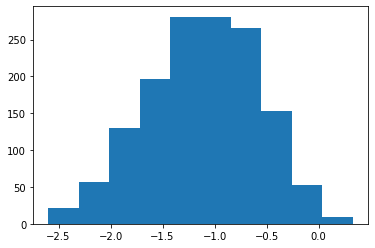

In [79]:
plt.hist(np.mean(predicted_train_lists,axis=0))
plt.show()

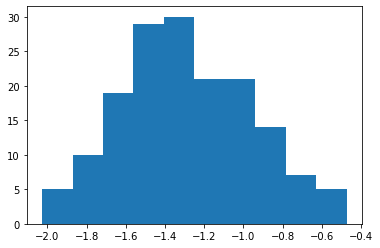

In [80]:
plt.hist(np.mean(predicted_test_lists,axis=0))
plt.show()

In [55]:
temp_list = [] 
for i in range(5):
  temp = np.arange(1445)
  temp_list.append(temp)

In [61]:
np.array(predicted_train_lists).shape

(5, 1606)

# 결과 

In [34]:
result = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Repositary/MRI_classification/최종결과/임시/Ex1_predicted.csv')

(array([1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456,
        1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467,
        1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478,
        1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489,
        1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500,
        1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511,
        1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522,
        1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533,
        1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544,
        1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555,
        1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566,
        1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577,
        1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588,
        1589, 1590, 1591, 1592, 1593, 